In [94]:
# Parallel_Bubble_Sort

import time
import random
import threading
start = time.perf_counter()

# create function to sort elements in odd phase
def odd_phase(lst,n):
        for i in range(0, n-1, 2):
                if lst[i] > lst[i+1]:
                        lst[i], lst[i+1] = lst[i+1], lst[i]

# create function to sort elements in even phase
def even_phase(lst,n):
        for i in range(1, n-1, 2):
                if lst[i] > lst[i+1]:
                        lst[i], lst[i+1] = lst[i+1], lst[i]

# create function to for parallel bubble sort
def Parallel_Bubble_Sort(lst):

        n = len(lst)
      
        # create list to keep track of all threads
        threads = []
        for i in range(1,n+1):
                
                # if i is odd, call for odd_phase function
                if (i % 2 == 1):
                        
                        # start threads one by one
                        t1 = threading.Thread(target=odd_phase,args = [lst,n])
                        t1.start()
                        threads.append(t1)
                        
                        # close all threads
                        for thread in threads:
                                thread.join()
                
                # if i is even, call for even_phase function
                else:
                        t2 = threading.Thread(target=even_phase,args = [lst,n])
                        t2.start()
                        threads.append(t2)
                                        
                        for thread in threads:
                                thread.join()
        
        # print final sorted list
        print('list after sorting:',lst)

# example list to test above program
lst = [(random.randint(0,1000)) for i in range(1000)]
print('list before sorting:',lst)
Parallel_Bubble_Sort(lst)
finish = time.perf_counter()
print(f'Finished in {round(finish-start,2)} sec')


list before sorting: [457, 253, 725, 473, 770, 904, 729, 809, 576, 845, 708, 630, 249, 729, 937, 736, 584, 849, 61, 464, 881, 55, 721, 349, 808, 73, 804, 123, 752, 19, 732, 275, 774, 198, 419, 25, 529, 835, 404, 888, 41, 777, 953, 177, 904, 118, 253, 855, 791, 914, 118, 730, 185, 509, 328, 140, 896, 213, 498, 821, 239, 252, 176, 919, 134, 413, 681, 219, 10, 697, 531, 373, 95, 796, 821, 684, 722, 968, 23, 615, 57, 921, 394, 863, 105, 654, 828, 21, 920, 209, 892, 198, 336, 185, 877, 80, 55, 235, 793, 297, 35, 883, 808, 142, 100, 240, 77, 759, 430, 780, 677, 889, 142, 39, 389, 427, 473, 440, 704, 104, 832, 575, 803, 42, 657, 359, 145, 467, 553, 20, 230, 251, 489, 777, 839, 729, 301, 380, 979, 921, 634, 827, 840, 765, 103, 340, 644, 714, 56, 752, 561, 295, 66, 149, 821, 613, 917, 539, 590, 722, 106, 722, 960, 538, 643, 807, 375, 475, 896, 836, 457, 944, 1000, 55, 636, 308, 501, 307, 720, 578, 533, 279, 912, 529, 790, 322, 701, 240, 747, 474, 26, 159, 480, 455, 276, 130, 113, 138, 633, 597,

In [95]:
# Parallel_quick_Sort

import random, time, sys
from multiprocessing import Process, Pipe

start = time.perf_counter()

def quicksort(lyst):

    if len(lyst) <= 1:
        return lyst
    pivot = lyst.pop(random.randint(0, len(lyst)-1))
    
    return quicksort([x for x in lyst if x < pivot]) \
           + [pivot] \
           + quicksort([x for x in lyst if x >= pivot])

def quicksortParallel(lyst, conn, procNum):
    """
    Partition the list, then quicksort the left and right
    sides in parallel.
    """

    if procNum <= 0 or len(lyst) <= 1:
        #In the case of len(lyst) <= 1, quicksort will
        #immediately return anyway.
        conn.send(quicksort(lyst))
        conn.close()
        return

    #Create two independent lists (independent in that
    #elements will never need be compared between lists).
    pivot = lyst.pop(random.randint(0, len(lyst)-1))

    leftSide = [x for x in lyst if x < pivot]
    rightSide = [x for x in lyst if x >= pivot]

    #Creat a Pipe to communicate with the left subprocess
    pconnLeft, cconnLeft = Pipe()
    #Create a leftProc that executes quicksortParallel on
    #the left half-list.
    leftProc = Process(target=quicksortParallel, \
                       args=(leftSide, cconnLeft, procNum - 1))
    
    #Again, for the right.
    pconnRight, cconnRight = Pipe()
    rightProc = Process(target=quicksortParallel, \
                       args=(rightSide, cconnRight, procNum - 1))

    #Start the two subprocesses.
    leftProc.start()
    rightProc.start()

    #Our answer is the concatenation of the subprocesses' 
    #answers, with the pivot in between. 
    conn.send(pconnLeft.recv() + [pivot] + pconnRight.recv())
    conn.close()

    #Join our subprocesses.
    leftProc.join()
    rightProc.join()

def isSorted(lyst):
    """
    Return whether the argument lyst is in non-decreasing order.
    """
    for i in range(1, len(lyst)):
        if lyst[i] < lyst[i-1]:
            return False
    return True

 #This is the main method, where we:
 #   -generate a random list.
 #   -time a parallel quicksort on the list.
  
    
#We want to sort the same list, so make a backup.
lystbck =  [(random.randint(0,1000)) for i in range(1000)]

#Parallel quicksort.
lyst = list(lystbck)

n = 2
#2**(n+1) - 1 processes will be instantiated.
#Instantiate a Pipe so that we can receive the
#process's response.
pconn, cconn = Pipe()

#Instantiate a process that executes quicksortParallel
#on the entire list.
p = Process(target=quicksortParallel, \
            args=(lyst, cconn, n))
p.start()

lyst = pconn.recv()
#Blocks until there is something (the sorted list)
#to receive.

p.join()

if not isSorted(lyst):
    print('quicksortParallel did not sort the lyst. oops.')

print('list before sorting:',lystbck)
print('list after sorting: ',lyst)
finish = time.perf_counter()
print(f'Finished in {round(finish-start,2)} sec')




list before sorting: [714, 275, 588, 39, 512, 562, 800, 618, 212, 906, 632, 9, 100, 8, 663, 889, 56, 980, 310, 110, 818, 282, 923, 761, 813, 401, 532, 528, 849, 389, 68, 832, 204, 757, 660, 109, 436, 623, 124, 280, 160, 152, 654, 435, 691, 590, 854, 494, 549, 347, 73, 352, 245, 604, 479, 947, 109, 103, 215, 218, 376, 337, 745, 214, 192, 818, 920, 764, 669, 3, 797, 829, 892, 514, 643, 271, 918, 48, 845, 767, 489, 525, 922, 349, 748, 50, 730, 702, 71, 712, 962, 105, 323, 333, 915, 244, 325, 868, 108, 259, 173, 544, 399, 610, 65, 750, 523, 640, 773, 222, 494, 920, 918, 990, 750, 603, 96, 320, 633, 270, 806, 500, 387, 912, 98, 162, 686, 355, 173, 778, 619, 272, 207, 586, 454, 382, 913, 67, 197, 854, 450, 246, 734, 768, 101, 710, 361, 589, 374, 733, 322, 185, 300, 136, 13, 998, 722, 292, 11, 597, 176, 411, 449, 374, 742, 197, 364, 588, 493, 683, 907, 943, 193, 13, 802, 576, 799, 766, 841, 571, 609, 532, 698, 828, 519, 132, 159, 451, 45, 352, 871, 73, 949, 747, 468, 388, 255, 564, 613, 501, 

In [97]:
# Parallel_merge_Sort

import math
import multiprocessing
import random
import sys
import time

start = time.perf_counter()


def merge(*args):
    # Support explicit left/right args, as well as a two-item
    # tuple which works more cleanly with multiprocessing.
    left, right = args[0] if len(args) == 1 else args
    left_length, right_length = len(left), len(right)
    left_index, right_index = 0, 0
    merged = []
    while left_index < left_length and right_index < right_length:
        if left[left_index] <= right[right_index]:
            merged.append(left[left_index])
            left_index += 1
        else:
            merged.append(right[right_index])
            right_index += 1
    if left_index == left_length:
        merged.extend(right[right_index:])
    else:
        merged.extend(left[left_index:])
    return merged


def merge_sort(data):
    length = len(data)
    if length <= 1:
        return data

    middle = length // 2
    left = merge_sort(data[:middle])
    right = merge_sort(data[middle:])
    return merge(left, right)


def merge_sort_parallel(data):
    # Creates a pool of worker processes, one per CPU core.
    # We then split the initial data into partitions, sized
    # equally per worker, and perform a regular merge sort
    # across each partition.
    processes = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=processes)
    size = int(math.ceil(float(len(data)) / processes))
    data = [data[i * size:(i + 1) * size] for i in range(processes)]
    data = pool.map(merge_sort, data)
    # Each partition is now sorted - we now just merge pairs of these
    # together using the worker pool, until the partitions are reduced
    # down to a single sorted result.
    while len(data) > 1:
        # If the number of partitions remaining is odd, we pop off the
        # last one and append it back after one iteration of this loop,
        # since we're only interested in pairs of partitions to merge.
        extra = data.pop() if len(data) % 2 == 1 else None
        data = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
        data = pool.map(merge, data) + ([extra] if extra else [])
    return data[0]



data_unsorted =  [(random.randint(0,1000)) for i in range(1000)]
print('list before sorting:', data_unsorted)

  
merg = merge_sort_parallel(data_unsorted)


print('list after sorting: ',merg)
finish = time.perf_counter()
print(f'Finished in {round(finish-start,2)} sec')


list before sorting: [450, 94, 511, 134, 900, 99, 972, 335, 282, 65, 974, 398, 382, 994, 227, 408, 468, 670, 635, 706, 627, 834, 81, 271, 846, 753, 926, 498, 504, 38, 500, 631, 988, 883, 278, 125, 228, 349, 189, 326, 816, 770, 373, 266, 908, 504, 832, 934, 228, 933, 667, 135, 948, 451, 473, 65, 400, 192, 350, 149, 427, 716, 357, 274, 759, 988, 555, 127, 752, 595, 476, 551, 432, 917, 493, 924, 256, 845, 806, 543, 881, 289, 88, 967, 279, 633, 891, 235, 367, 513, 936, 649, 74, 661, 65, 364, 698, 270, 133, 980, 981, 780, 803, 938, 683, 702, 418, 221, 785, 367, 120, 790, 395, 352, 300, 680, 393, 310, 447, 904, 827, 963, 665, 713, 714, 116, 748, 820, 384, 485, 976, 58, 642, 574, 715, 210, 585, 826, 435, 7, 601, 864, 120, 802, 147, 946, 376, 673, 375, 952, 530, 72, 321, 97, 695, 953, 583, 731, 911, 322, 232, 997, 775, 294, 247, 2, 403, 962, 927, 240, 891, 985, 676, 160, 343, 749, 667, 879, 841, 312, 586, 285, 675, 791, 649, 985, 451, 984, 201, 264, 746, 177, 453, 60, 769, 383, 550, 614, 312, 

In [89]:
# parallel_Depth_search
from multiprocessing.dummy import Pool as ThreadPool

start = time.perf_counter()

def dfs(visited, graph, node):
    if node not in visited:
        visited.add(node)
        for neighbour in graph[node]:
            dfs(visited, graph, neighbour)



visited = set()
graph = {
    'A': ['B', 'C'],
    'B': ['D', 'E'],
    'C': ['F'],
    'D': [],
    'E': ['F'],
    'F': ['H','I'],
    'H': ['G', 'K'],
    'I':['L'],
    'L':[],
    'G':[],
    'K':['G']
}

a = [visited, visited]
b = [graph, graph]
c = ['B', 'C']

pool = ThreadPool(2)
pool.starmap(dfs, zip(a, b, c))
pool.close()
pool.join()

print(visited)
finish = time.perf_counter()
print(f'Finished in {round(finish-start,2)} sec')

{'C', 'F', 'H', 'K', 'I', 'L', 'B', 'G', 'D', 'E'}
Finished in 0.01 sec


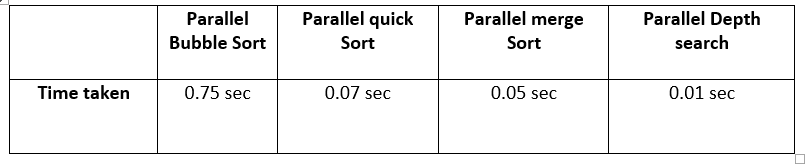